In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from Farm_Evaluator import getTurbLoc, loadPowerCurve, binWindResourceData, preProcessing, getAEP, checkConstraints

In [ ]:
power_curve   =  loadPowerCurve('power_curve.csv')
turb_rad = 50

In [ ]:
n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing(power_curve)

In [ ]:
# Years on which the data is available
year_list = ['2007','2008','2009','2013','2014','2015','2017']

wind_data_list = []
for year in year_list:
    wind_data_list.append(pd.read_csv("wind_data_{}.csv".format(year)))

In [ ]:
# Problem parameter
min_lim = 50.0
max_lim = 3950.0
turb_count = 50
penalty = 0.05
proximity = 400.0

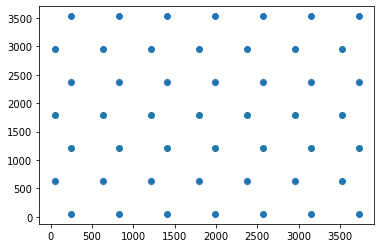

In [ ]:
## Possible turbine locations
Xt = np.arange(min_lim, max_lim, proximity)
Yt = np.arange(min_lim, max_lim, proximity)

Xt, Yt = np.meshgrid(Xt, Yt)
Xt[::2] += 400/2
turbs_possible_locs = np.vstack([Xt.flatten(), Yt.flatten()]).T

plt.scatter(turbs_possible_locs[:,0], turbs_possible_locs[:,1])

In [ ]:
def calculate_AEP(idx):
    turb_coords = turbs_possible_locs[idx,:]
    aep = []
    for wind_data in wind_data_list:
        wind_inst_freq =  binWindResourceData(wind_data)
        aep.append(getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
                  n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t))
    return sum(aep)/len(aep)

In [ ]:
class TurbGroup:
    def __init__(self):
        self.turb_idx = np.random.choice(turbs_possible_locs.shape[0], turb_count, replace=False)
        self.fitness = -1
                    
    def calculate_fitness(self):
        fitness = calculate_AEP(self.turb_idx)
        self.fitness = fitness


In [ ]:
def ga():

    pop = init_pop(POP_SIZE)
    pop = fitness(pop)
    
    for generation in range(GEN_COUNT):    
        
        nextgen_pop = []
        for i in range(int(POP_SIZE/2)):
            parent1 = selection(pop)
            parent2 = selection(pop)
            offsprings = crossover(parent1, parent2)
            nextgen_pop.append(mutation(offsprings[0]))
            nextgen_pop.append(mutation(offsprings[1]))
        pop = fitness(nextgen_pop)
        best = sorted(pop, key=lambda x: x.fitness, reverse=True)
        print("Best fit in Generation no {}: {}".format(generation, best[0].fitness))
    return best[0]


In [ ]:
def init_pop(population_count):
    return [TurbGroup() for _ in range(population_count)]

In [ ]:
def fitness(population):
    for agent in population:
        agent.calculate_fitness()
    return population

In [ ]:
def selection(population):
    players = random.sample(population, TOURNAMENT_SIZE)
    sorted_players = sorted(players, key=lambda x: x.fitness, reverse=True)

    return sorted_players[0]

In [ ]:
def set_diff2d(A, B):
    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
           'formats':ncols * [A.dtype]}
    C = np.setdiff1d(A.view(dtype), B.view(dtype))   
    return C.view(A.dtype).reshape(-1, ncols)

In [ ]:
def remove_copies_and_append_new_location(locs):
    locs = np.unique(locs)
    diff = turb_count - locs.shape[0]
    if diff > 0:
        new_pool = np.setdiff1d(np.arange(turbs_possible_locs.shape[0]), locs)
        new_locs = np.random.choice(new_pool, diff, replace=False)
        locs = np.append(new_locs, locs)
    return locs

In [ ]:
def crossover(p1, p2):
    if random.random() < XO_PROB: 

        xo_pt = np.random.randint(turb_count)
        
        c = np.append(p1.turb_idx[:xo_pt], p2.turb_idx[xo_pt:])
        d = np.append(p2.turb_idx[:xo_pt], p1.turb_idx[xo_pt:])
        
        # If contains duplicate, remove and add new locs
        c = remove_copies_and_append_new_location(c)
        d = remove_copies_and_append_new_location(d)
        
        p1.turb_coords = c
        p2.turb_coords = d
        
    return p1, p2

In [ ]:
def mutation(agent):
    if random.random() < MUT_PROB:
        return TurbGroup()
    else:
        return agent

In [ ]:
# GA parameters
POP_SIZE = 50
GEN_COUNT = 25
TOURNAMENT_SIZE = 20
MUT_PROB = 0.2
XO_PROB = 0.80

In [ ]:
# best_fit is an instance of the class TurbGroup
# you can get the location using the attribute turb_idx
# eg: turbs_possible_locs[best_fit.turb_idx, :]
best_fit = ga()

ValueError: ignored

In [ ]:
loc = turbs_possible_locs[best_fit.turb_coords, :]

NameError: ignored

In [ ]:
plt.scatter(loc[:,0], loc[:,1], c='black')